# How is the distribution of funding per vision?

In [1]:
from swinno_bioeconomy_directionality.config import EXTERNAL_DATA_DIR, RAW_DATA_DIR

import polars as pl
import polars.selectors as cs
import pandas as pd
import seaborn.objects as so
import matplotlib.pyplot as plt

2024-11-05 15:23:58.485 | INFO     | swinno_bioeconomy_directionality.config:<module>:7 - PROJ_ROOT path is: /Users/research/projects/swinno_bioeconomy_directionality


In [2]:
funding_data_path = EXTERNAL_DATA_DIR / "regression_data_final.dta"
funding_labels = pd.read_stata(funding_data_path, iterator=True).variable_labels()

funding = (
    pl.from_pandas(pd.read_stata(funding_data_path))
    .rename({"id": "sinno_id", "PF": "public_funding"})
    .with_columns(
        pl.col("sinno_id").cast(pl.Int64),
        pl.col("public_funding").cast(pl.Boolean),
        pl.col("year").cast(pl.Int32),
    )
)

In [3]:
funding.head()

sinno_id,year,public_funding,L,F,E,R,C,P_before,S,lS,T,past_Inno,past_PF,DistributionTransmission,Electricity,Efficiency,Emissions,Fuel,Heat,Storage,Biomass,Fossil,Geo,Hydro,Nuclear,Ocean,Solar,Waste,Wind,polhem,nyt33,wikipedia,literature,first_PF,PF_5y,PF_10y
i64,i32,bool,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
5870001,1972,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0
5871001,1972,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0
5872001,1972,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,null,0.0,0.0
5873001,1973,false,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,0.0,0.0
5874001,1972,true,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1974.0,0.0,0.0


In [4]:
bioeconomy_visions = (
    pl.read_csv(RAW_DATA_DIR / "bioeconomy_visions.csv")
    .with_columns(
        pl.col("bioeconomy_vision").str.replace("Not Bioeconomy", "Vision Neutral")
    )
    .filter(pl.col("bioeconomy_vision") != "Unsure")
)

In [5]:
visions_funding = bioeconomy_visions.join(
    funding.select(["public_funding", "sinno_id"]), on="sinno_id"
)
visions_funding

sinno_id,bioeconomy_vision,year,public_funding
i64,str,i64,bool
5880001,"""Vision Neutral""",1975,false
5881001,"""Bioresource Vision""",1975,false
5883001,"""Bioresource Vision""",1976,false
5894001,"""Vision Neutral""",1974,false
5897001,"""Vision Neutral""",1979,false
…,…,…,…
16230001,"""Bioecology Vision""",2021,true
16239001,"""Bioecology Vision""",2020,false
16243001,"""Vision Neutral""",2021,true


First a look at the funding shares within each vision.

In [6]:
(
    visions_funding.group_by("bioeconomy_vision")
    .agg(
        pl.col("public_funding").sum().alias("funded"),
        pl.col("public_funding").count().alias("total"),
    )
    .with_columns((pl.col("funded") / pl.col("total")).alias("share_funded"))
)

bioeconomy_vision,funded,total,share_funded
str,u32,u32,f64
"""Vision Neutral""",70,355,0.197183
"""Biotechnology Vision""",15,41,0.365854
"""Bioresource Vision""",64,263,0.243346
"""Bioecology Vision""",28,93,0.301075


Next share as total of all bioeconomy innovation.

In [7]:
(
    visions_funding.with_columns(
        (pl.col("bioeconomy_vision") != "Vision Neutral").alias("bioeconomy")
    )
    .with_columns(
        pl.col("bioeconomy").sum().alias("sum_bioeconomy"),
        pl.col("public_funding").sum().over("bioeconomy_vision").alias("funded"),
    )
    .with_columns((pl.col("funded") / pl.col("sum_bioeconomy")).alias("share_funded"))
    .select(["bioeconomy_vision", "funded", "sum_bioeconomy", "share_funded"])
    .unique()
)

bioeconomy_vision,funded,sum_bioeconomy,share_funded
str,u32,u32,f64
"""Bioecology Vision""",28,397,0.070529
"""Vision Neutral""",70,397,0.176322
"""Biotechnology Vision""",15,397,0.037783
"""Bioresource Vision""",64,397,0.161209


Of the bioeconomy innovations, the most funded innovations were in the Bioresource vision. But need to normalize by group size to make them comparable. 

In [8]:
visions_funding.group_by()

Next a look at the shares of visions out of all funded bioeconomy innovations?


In [9]:
funding = funding.join(
    bioeconomy_visions.select(["sinno_id", "bioeconomy_vision"]),
    on="sinno_id",
    how="left",
).select(["sinno_id", "year", "public_funding", "bioeconomy_vision"])


In [10]:
funding = funding.with_columns(
    pl.col("bioeconomy_vision").is_not_null().alias("bioeconomy")
)

In [11]:
(
    funding.group_by("bioeconomy")
    .agg(
        pl.col("public_funding").sum().alias("funded"),
        pl.col("public_funding").count().alias("total"),
    )
    .with_columns((pl.col("funded") / pl.col("total")).alias("share"))
)

bioeconomy,funded,total,share
bool,u32,u32,f64
false,1020,4185,0.243728
true,177,752,0.235372


In [12]:
share_per_group = (
    funding.filter(pl.col("bioeconomy_vision").is_not_null())
    .group_by(["bioeconomy_vision"])
    .agg(
        pl.col("public_funding").sum().alias("funded"),
        pl.col("public_funding").count().alias("total"),
    )
    .with_columns(
        (pl.col("funded") / pl.col("total")).alias("share"),
        pl.col("total").sum().alias("total_innovation"),
    )
    .with_columns(
        (pl.col("total") / pl.col("total_innovation")).alias("share_vision_innovation")
    )
    .with_columns(
        (pl.col("share") * pl.col("share_vision_innovation")).alias(
            "share_funded_x_share_total"
        )
    )
)
share_per_group

bioeconomy_vision,funded,total,share,total_innovation,share_vision_innovation,share_funded_x_share_total
str,u32,u32,f64,u32,f64,f64
"""Biotechnology Vision""",15,41,0.365854,752,0.054521,0.019947
"""Bioecology Vision""",28,93,0.301075,752,0.12367,0.037234
"""Bioresource Vision""",64,263,0.243346,752,0.349734,0.085106
"""Vision Neutral""",70,355,0.197183,752,0.472074,0.093085


In [13]:
share_per_group_yearly = (
    funding.filter(pl.col("bioeconomy_vision").is_not_null())
    .group_by(["year", "bioeconomy_vision"])
    .agg(
        pl.col("public_funding").sum().alias("funded"),
        pl.col("public_funding").count().alias("total"),
    )
    .with_columns(
        (pl.col("funded") / pl.col("total")).alias("share"),
        pl.col("total").sum().alias("total_innovation"),
    )
    .with_columns(
        (pl.col("total") / pl.col("total_innovation")).alias("share_vision_innovation")
    )
    .with_columns(
        (pl.col("share") * pl.col("share_vision_innovation")).alias(
            "share_funded_x_share_total"
        )
    )
)
share_per_group_yearly.sort("year")

year,bioeconomy_vision,funded,total,share,total_innovation,share_vision_innovation,share_funded_x_share_total
i32,str,u32,u32,f64,u32,f64,f64
1970,"""Bioecology Vision""",1,3,0.333333,752,0.003989,0.00133
1970,"""Bioresource Vision""",0,3,0.0,752,0.003989,0.0
1970,"""Vision Neutral""",1,10,0.1,752,0.013298,0.00133
1970,"""Biotechnology Vision""",1,3,0.333333,752,0.003989,0.00133
1971,"""Vision Neutral""",1,11,0.090909,752,0.014628,0.00133
…,…,…,…,…,…,…,…
2020,"""Bioresource Vision""",2,2,1.0,752,0.00266,0.00266
2020,"""Bioecology Vision""",2,3,0.666667,752,0.003989,0.00266
2021,"""Bioresource Vision""",1,2,0.5,752,0.00266,0.00133


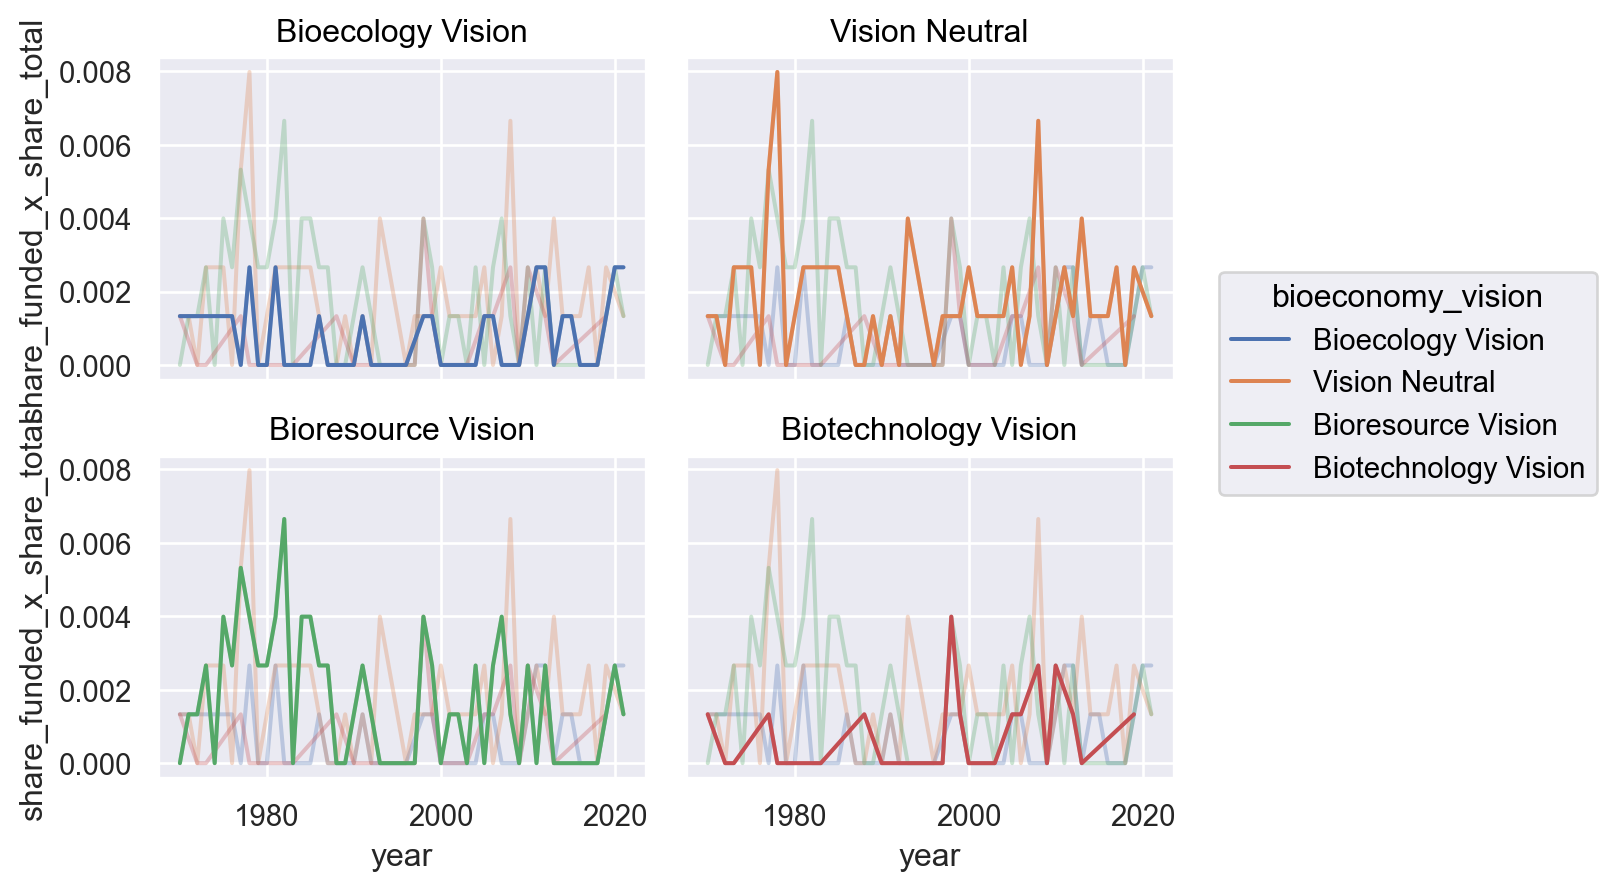

In [14]:
(
    so.Plot(
        share_per_group_yearly,
        x="year",
        y="share_funded_x_share_total",
        color="bioeconomy_vision",
    )
    .facet("bioeconomy_vision", wrap=2)
    .add(so.Line(alpha=0.3), col=None)
    .add(so.Line())
)

Normalized for group size

In [15]:
s_total = share_per_group.select("share").sum().item()

normalized_share = share_per_group.select(
    ["bioeconomy_vision", "funded", "total", "share"]
).with_columns(pl.col("share") / s_total)

normalized_share

bioeconomy_vision,funded,total,share
str,u32,u32,f64
"""Biotechnology Vision""",15,41,0.330354
"""Bioecology Vision""",28,93,0.271862
"""Bioresource Vision""",64,263,0.219734
"""Vision Neutral""",70,355,0.17805


In [16]:
normalized_share = normalized_share.with_columns(
    pl.exclude("bioeconomy_vision").cum_sum().name.prefix("cum_")
)
normalized_share

normalized_share.select("cum_total").max().item()

752

In [59]:
share_per_group_yearly = share_per_group_yearly.with_columns(
    pl.col("share").sum().over("year").alias("share_year")
).sort("year")

normalized_share_year = (
    share_per_group_yearly.select(
        ["bioeconomy_vision", "funded", "total", "year", "share", "share_year"]
    )
    .fill_null(0)
    .fill_nan(0)
    .with_columns((pl.col("share") / pl.col("share_year")).alias("share_normalized"))
)

normalized_share_year

bioeconomy_vision,funded,total,year,share,share_year,share_normalized
str,u32,u32,i32,f64,f64,f64
"""Bioecology Vision""",1,3,1970,0.333333,0.766667,0.434783
"""Bioresource Vision""",0,3,1970,0.0,0.766667,0.0
"""Vision Neutral""",1,10,1970,0.1,0.766667,0.130435
"""Biotechnology Vision""",1,3,1970,0.333333,0.766667,0.434783
"""Vision Neutral""",1,11,1971,0.090909,0.457576,0.198675
…,…,…,…,…,…,…
"""Bioresource Vision""",2,2,2020,1.0,1.666667,0.6
"""Bioecology Vision""",2,3,2020,0.666667,1.666667,0.4
"""Bioresource Vision""",1,2,2021,0.5,1.333333,0.375


In [60]:
normalized_cum_share_year = normalized_share_year.fill_nan(0).with_columns(pl.col("share_normalized").cum_sum().over("year").alias("cum_share"))

normalized_cum_share_year_wide = normalized_cum_share_year.pivot(index="year", on="bioeconomy_vision", values="cum_share")

normalized_share_wide = normalized_share_year.pivot(index="year", on="bioeconomy_vision", values="share_normalized")



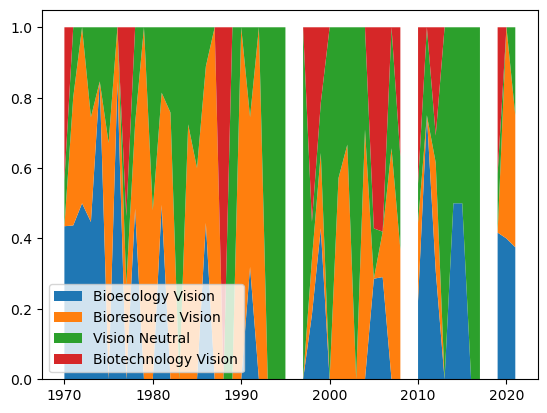

In [63]:
fig, ax = plt.subplots()

x = normalized_share_wide.select("year").to_series().to_list()
shares = normalized_share_wide.select(pl.exclude("year")).fill_null(0).to_dict(as_series=False)

ax.stackplot(x, shares.values(), labels=shares.keys())
ax.legend()

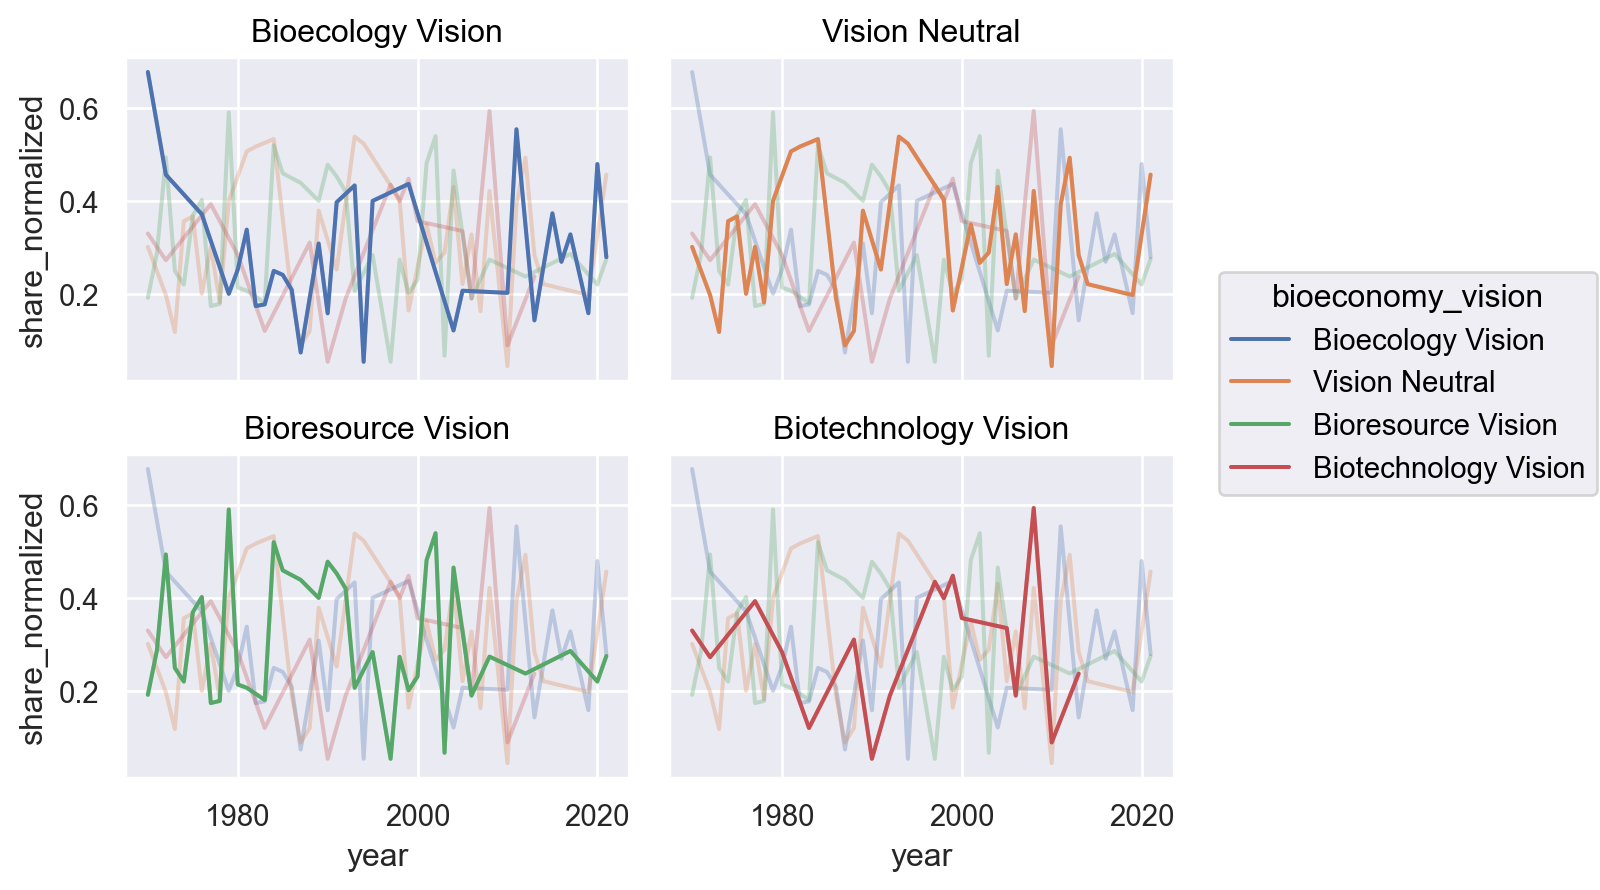

In [23]:
(
    so.Plot(
        normalized_share_year.with_columns(pl.col("share_normalized").rolling_mean(5)),
        x="year",
        y="share_normalized",
        color="bioeconomy_vision",
    )
    .facet("bioeconomy_vision", wrap=2)
    .add(so.Line(alpha=0.3), col=None)
    .add(so.Line())
)

In [18]:
filter_column = "public_funding"
group_by_column = "bioeconomy_vision"

bv_of_funded = (
    funding.filter(pl.col(filter_column))
    .with_columns(pl.col(group_by_column).str.replace(" ", "_").str.to_lowercase())
    .group_by([group_by_column, "year"])
    .agg(pl.col("sinno_id").count())
    .sort("year")
    .pivot(index="year", on=group_by_column)
    .fill_null(0)
    .with_columns(pl.sum_horizontal(pl.exclude("year")).alias("total_funding"))
    .with_columns((pl.exclude("year") / pl.col("total_funding")).name.prefix("share_"))
)

In [19]:
bv_of_funded = bv_of_funded.select(["year", cs.starts_with("share_")]).unpivot(
    index="year"
)

In [20]:
bv_of_funded

year,variable,value
i32,str,f64
1970,"""share_bioecology_vision""",0.166667
1971,"""share_bioecology_vision""",0.125
1972,"""share_bioecology_vision""",0.090909
1973,"""share_bioecology_vision""",0.055556
1974,"""share_bioecology_vision""",0.083333
…,…,…
2017,"""share_total_funding""",1.0
2018,"""share_total_funding""",1.0
2019,"""share_total_funding""",1.0


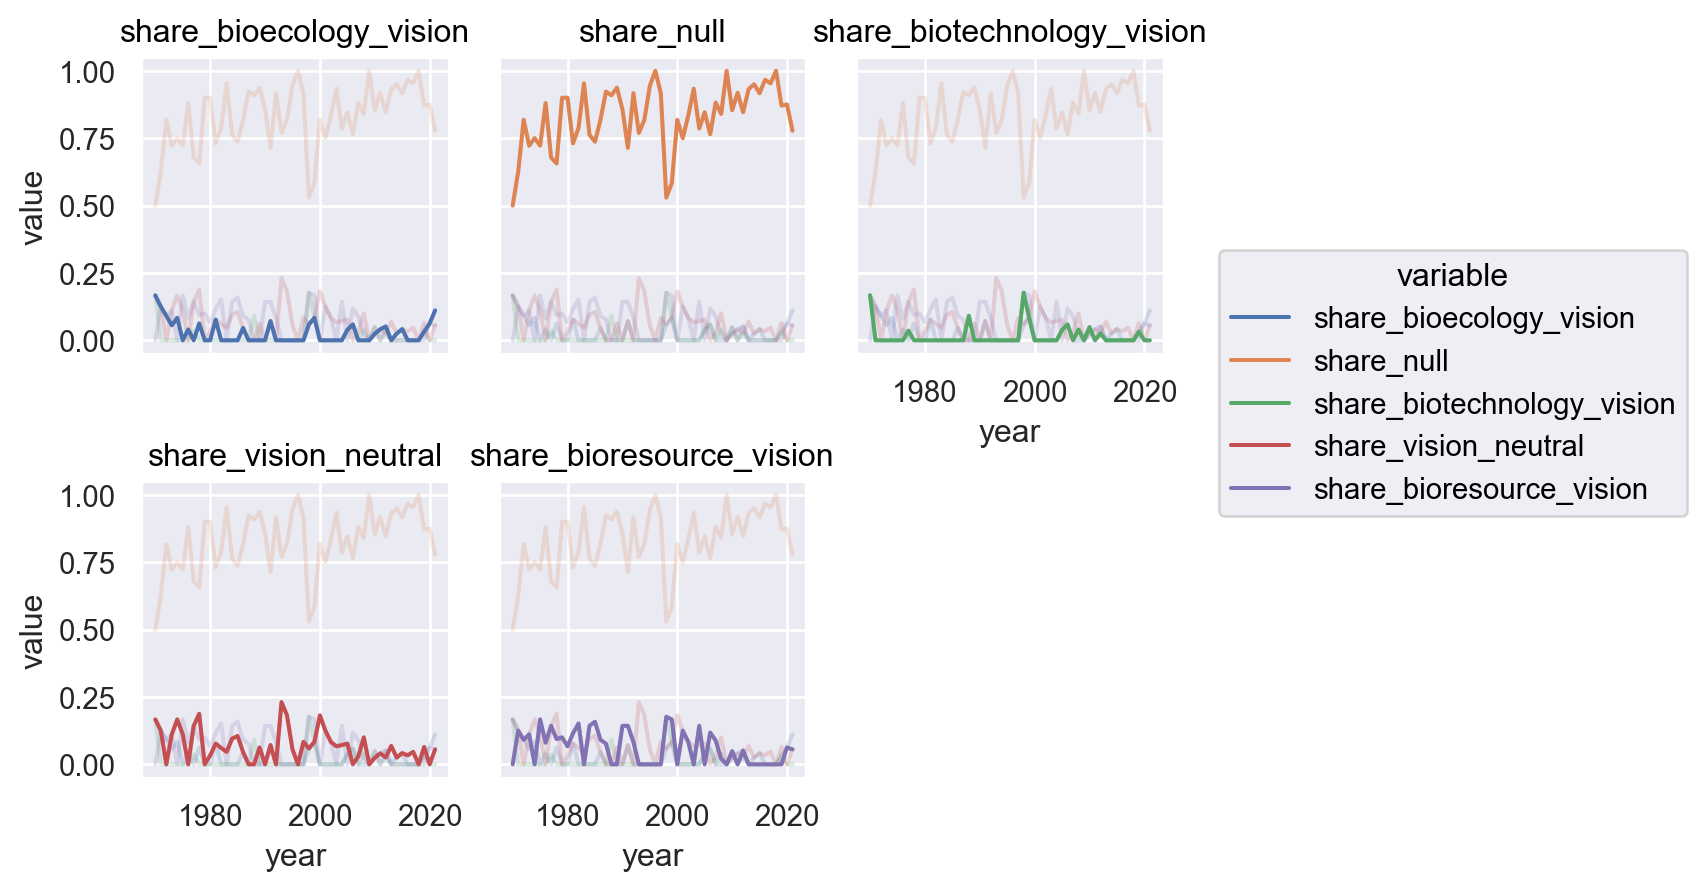

In [21]:
(
    so.Plot(
        bv_of_funded.filter(pl.col("variable") != "share_total_funding"),
        x="year",
        y="value",
    )
    .facet("variable", wrap=3)
    .add(so.Line(alpha=0.2), group="variable", color="variable", col=None)
    .add(so.Line(), color="variable")
)